In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found

Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)



In [10]:
# I want to see what is inside measurement

from sqlalchemy import inspect
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
       print(c["name"],c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# I want to see what is inside station

from sqlalchemy import inspect

columns = inspector.get_columns('station')
for c in columns:
      print(c["name"],c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

    # What is the latest date?
    # What is the date from 1 year earlier?

#find the last date (str - formated as text) in the db (class measurement)

latest_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# create date object from string
latest_date = dt.datetime.strptime(latest_str[0],'%Y-%m-%d')

# find date from 1 year prior to the latest date in the db
yearago_date = dt.date(latest_date.year-1,latest_date.month, latest_date.day)


print(latest_date, yearago_date)    



2017-08-23 00:00:00 2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores

query = (Measurement.date, Measurement.prcp)

data_prcp = session.query(*query).\
            filter(Measurement.date >= yearago_date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(data_prcp,columns=['date','precipitation'])

# Sort the dataframe by date

prcp_df.set_index('date',inplace=True)
prcp_df = prcp_df.dropna(how='any')
prcp_df = prcp_df.sort_index()

prcp_df.head()


,precipitation
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


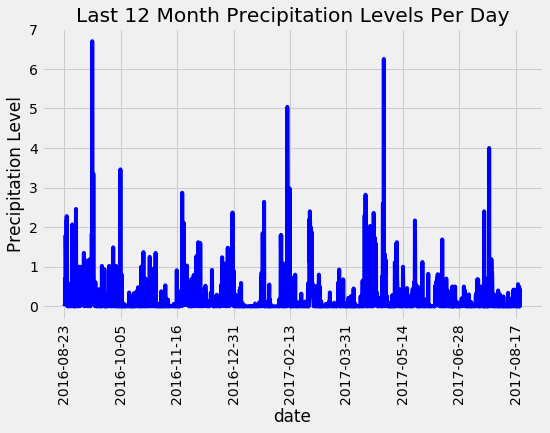

In [14]:

# Use Pandas Plotting with Matplotlib to plot the data

ax = prcp_df.plot(rot=90,figsize = (8,5), color = "b", legend=False);
ax.set_title("Last 12 Month Precipitation Levels Per Day");
ax.set_ylabel("Precipitation Level");




In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

moststations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
moststations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

USC00519281 has the highest number of observations

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station for the last 12 months.

session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

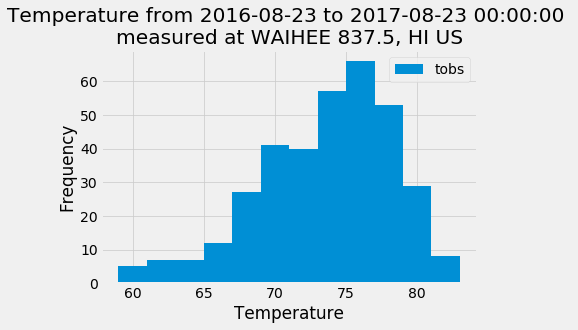

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

querystation = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= yearago_date).all()
temperatures = list(np.ravel(querystation))

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
querystation = session.query(*sel).all()
stations = pd.DataFrame(querystation, columns=['Station','Name','Latitude','Longitude','Elevation'])

selectedstation = stations.loc[stations["Station"] == 'USC00519281',"Name"].tolist()[0]

plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.xlabel('Temperature')

plt.title(f"Temperature from {yearago_date} to {latest_date} \nmeasured at {selectedstation}")
plt.legend()


## Bonus Challenge Assignment

In [20]:
# ### Temperature Analysis I

# * Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

# * You may either use SQLAlchemy or pandas's `read_csv()` to perform this portion.

# * Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

# * Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

# return the raw data from each month, June and December
june_data = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m",Measurement.date) == '06').all()
december_data = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m",Measurement.date) == '12').all()

# convert raw data to DataFrames to label them and then concatenate into one DataFrame
june_df = pd.DataFrame(june_data,columns=["Date","Temperature"])
december_df = pd.DataFrame(december_data,columns=["Date","Temperature"])
june_df["Month"] = "June"
december_df["Month"] = "December"
temp_df = pd.concat([june_df,december_df], ignore_index=True)

# calculate the average for both June and December
avg_temp_month = temp_df.groupby("Month").mean()
avg_temp_month

,Temperature
Month,
December,71.041529
June,74.944118


In [21]:

# Statistics

stats.ttest_ind(june_df["Temperature"], december_df["Temperature"])

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

As can be seen above, there is a difference in averages between June and December.  Using an unpaired t-test (the samples are not related by the same timeframe)...the p-value is very low...less than 5%..meaning the differences are not random...the difference is statistically significant



In [22]:
### Temperature Analysis II
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-04-10', '2016-04-17'))

[(66.0, 74.02127659574468, 80.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

startdate = '2017-05-01'
enddate = '2017-05-10'
minavgmaxtemp = calc_temps(startdate,enddate)[0]
minavgmaxtemp

(65.0, 75.12280701754386, 80.0)

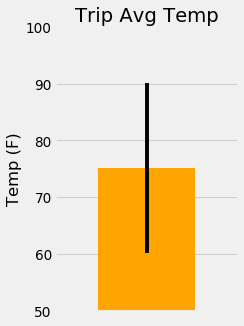

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_pos = [0]
y_pos = [minavgmaxtemp[1]]
error = [(minavgmaxtemp[2] - minavgmaxtemp[0])]

w = 3
h = 5
d = 70
plt.figure(figsize=(w, h), dpi=d)
plt.bar(x_pos,y_pos,color='orange', yerr=error)
plt.xlim(-.75,.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.ylim(50, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

startdate = '2017-05-01'
enddate = '2017-05-10'

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
queryresult = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= startdate).\
    filter(Measurement.date <= enddate).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()
  
stations = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation','PrcpSum'])
stations


,Station,Name,Latitude,Longitude,Elevation,PrcpSum
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.68
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.27
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.07
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.94
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.81
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.26


In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("05-05")

[(67.0, 73.39655172413794, 79.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

startdate = '2018-05-01'
enddate = '2018-05-10'

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


start = dt.datetime.strptime(startdate, '%Y-%m-%d')
end = dt.datetime.strptime(enddate, '%Y-%m-%d')

tripdates = []
normals =[]
while (start <= end):
    tripdates.append(dt.datetime.strftime(start,'%Y-%m-%d'))
    datestr = dt.datetime.strftime(start,'%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    start = start + dt.timedelta(days = 1)

normals


[[65.0, 72.75925925925925, 79.0],
 [65.0, 73.05084745762711, 79.0],
 [67.0, 73.41071428571429, 84.0],
 [65.0, 73.59649122807018, 78.0],
 [67.0, 73.39655172413794, 79.0],
 [66.0, 73.14035087719299, 80.0],
 [64.0, 71.78846153846153, 79.0],
 [65.0, 72.18867924528301, 80.0],
 [67.0, 72.9322033898305, 79.0],
 [64.0, 73.3157894736842, 78.0]]

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
tripnormals = pd.DataFrame(normals, columns=['tmin','tavg','tmax'])
tripnormals['Date'] = tripdates
tripnormals = tripnormals.set_index("Date")
tripnormals

,tmin,tavg,tmax
Date,,,
2018-05-01,65.0,72.759259,79.0
2018-05-02,65.0,73.050847,79.0
2018-05-03,67.0,73.410714,84.0
2018-05-04,65.0,73.596491,78.0
2018-05-05,67.0,73.396552,79.0
2018-05-06,66.0,73.140351,80.0
2018-05-07,64.0,71.788462,79.0
2018-05-08,65.0,72.188679,80.0
2018-05-09,67.0,72.932203,79.0


(array([-2.,  0.,  2.,  4.,  6.,  8., 10.]),
 <a list of 7 Text xticklabel objects>)

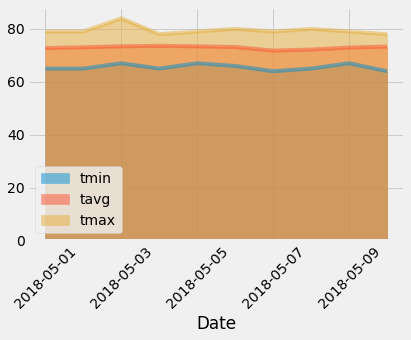

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
tripnormals.plot.area(stacked=False)
plt.xticks(rotation=45)